In [1]:
#!pip3 install --user astropy

In [350]:
import numpy as np
import astropy as ap
import pandas as pd
from astropy.io import fits
import scipy.linalg as slg
from scipy.stats import norm

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap
import glob
import os

from IPython.display import Image
from IPython.display import display

In [166]:
run_path2 = "/home/portmanm/run2_1000_galfit"
run_path6 = "/home/portmanm/run6_1000_galfit_two_fit"
#run_path = "/home/portmanm/run3_1000_galfit_psf"
sparc_in = "sparcfire-in"
sparc_out = "sparcfire-out"
sparc_tmp = "sparcfire-tmp"
galfits_tmp = "galfits"
galfit_masks = "galfit_masks"
galfit_out = "all_galfit_out"

In [125]:
def check_galfit_chi(gal_name, base_path):
    # An example line
    # # Chi^2/nu = 4.661,  Chi^2 = 12025.575,  Ndof = 2580
    
    galfit_txt_out = "galfit.01" # in the future galfit.01 may change
    filename = os.path.join(base_path, gal_name, galfit_txt_out)
    with open(filename, "r") as f:
        for line in f:
            if "Chi" in line:
                chi_line = line.strip("# ")
    
    # This also works but it's quite devious...
    # chi_line.replace("^", "").replace("/", "_").replace(",  ", "\n").lower()
    # exec(chi_line)
    
    out_vals = chi_line.split(",")
    chi2_nu = float(out_vals[0].strip().split("=")[-1])
    chi2 = float(out_vals[1].strip().split("=")[-1])
    ndof = int(out_vals[2].strip().split("=")[-1])
    
    return chi2_nu, chi2, ndof

In [167]:
norms_2 = {}
norms_6 = {}

In [168]:
#residual_arrays = {}
for run_path, norms in zip([run_path2, run_path6], [norms_2, norms_6]):
    total_gal = len(glob.glob(os.path.join(run_path, sparc_in, "*.fits")))
    outpath = os.path.join(run_path, sparc_out)#, galfit_out)
    temppath = os.path.join(run_path, sparc_tmp, galfits_tmp)
    maskpath  = os.path.join(run_path, sparc_tmp, galfit_masks)
    #successes = [os.path.basename(i) for i in glob.glob(os.path.join(temppath, "*.fits"))]

    for i in glob.glob(os.path.join(temppath, "*.fits")):
        fits_file = fits.open(i)
        filename  = os.path.basename(i)
        galaxy_name = filename.split("_")[0]

        star_mask_name = f"{galaxy_name}_star-rm.fits"

        mask_fits_name = os.path.join(maskpath, star_mask_name)
        mask_fits_file = fits.open(mask_fits_name)

        crop_box = fits_file[2].header["FITSECT"]
        crop_box = eval(crop_box.replace(":", ","))

        # To adjust for python indexing
        box_min, box_max = crop_box[0] - 1, crop_box[1]

        # To invert the matrix since galfit keeps 0 valued areas 
        crop_mask = 1 - mask_fits_file[0].data[box_min:box_max, box_min:box_max]
        #print(mask_fits_file[0].data[box_min:box_max, box_min:box_max])
        #print(star_mask_name)

        try:
            #masked_observation = fits_file[1].data - (fits_file[1].data * crop_mask)
            observation = fits_file[1].data
            #masked_model = fits_file[2].data - (fits_file[2].data*crop_mask)
            model = fits_file[2].data
            masked_residual = (observation - model)*crop_mask
            masked_residual_normalized = masked_residual/slg.norm(crop_mask*(observation + model)) #masked_residual)
            #print("obs, model, residual")
            #print(f"|{slg.norm(observation):.3f} - {slg.norm(model):.3f} | = {slg.norm(masked_residual_normalized):.6f}")
            #print()

        except:
            print(f"There is likely an observation error with galaxy {galaxy_name}, continuing...")
            #print(np.shape(mask_fits_file[0].data))
            #print(np.shape(fits_file[1].data))
            #print(crop_box)
            continue

        #residual = masked_observation - masked_model
        #residual_arrays[filename] = residual

        try:
            norms[filename] = *check_galfit_chi(galaxy_name, outpath)[:2], slg.norm(masked_residual_normalized), slg.norm(fits_file[3].data), masked_residual_normalized
            #print(f"{galaxy_name}", round(slg.norm(residual), 3))
            #norms[filename] = check_galfit_chi(galaxy_name, outpath)[:2]#, slg.norm(fits_file[3].data)
        # for infs, nans in residual
        except ValueError:
            pass

        except FileNotFoundError:
            print(f"Could not find galfit.# output file for {filename}. Continuing...")
            pass

        fits_file.close()
        mask_fits_file.close()
    #glob.glob("./" + galaxy_path + '/' + galaxy_name + '.tsv')[0]

There is likely an observation error with galaxy 1237667910602522764, continuing...
There is likely an observation error with galaxy 1237671140406919323, continuing...
There is likely an observation error with galaxy 1237667910602522764, continuing...
There is likely an observation error with galaxy 1237671140406919323, continuing...
There is likely an observation error with galaxy 1237678596459267156, continuing...


In [177]:
nmr = "norm_masked_residual"

In [182]:
norms2_df = pd.DataFrame(norms_2).T
norms6_df = pd.DataFrame(norms_6).T

norms2_df.rename(columns={0: 'chi^2_nu', 1: 'chi^2', 2 : nmr, 3 : 'norm_galfit_residual', 4 : 'masked_residual_array'}, inplace=True)
norms6_df.rename(columns={0: 'chi^2_nu', 1: 'chi^2', 2 : nmr, 3 : 'norm_galfit_residual', 4 : 'masked_residual_array'}, inplace=True)

In [183]:
norms2_df = norms2_df.sort_values(by=[nmr]) #, inplace=True)
norms6_df = norms6_df.sort_values(by=[nmr]) #, inplace=True)

In [192]:
norms2_df["image_size"] = norms2_df["masked_residual_array"].map(lambda x: len(x))
norms6_df["image_size"] = norms6_df["masked_residual_array"].map(lambda x: len(x))

In [205]:
nmr2_lim = norms2_df[norms2_df.norm_masked_residual < 0.01]
nmr6_lim = norms6_df[norms6_df.norm_masked_residual < 0.01]

In [291]:
run2_name = " Bulge+Disk+Arms"
run6_name = " Bulge, Disk+Arms"

In [292]:
graphing_df = pd.DataFrame()
graphing_df[run2_name] = nmr2_lim[nmr]
graphing_df[run6_name] = nmr6_lim[nmr]

In [293]:
graphing_df = graphing_df.melt(id_vars = [], value_vars = [run2_name, run6_name], var_name = "Run ", value_name = nmr, ignore_index = False)

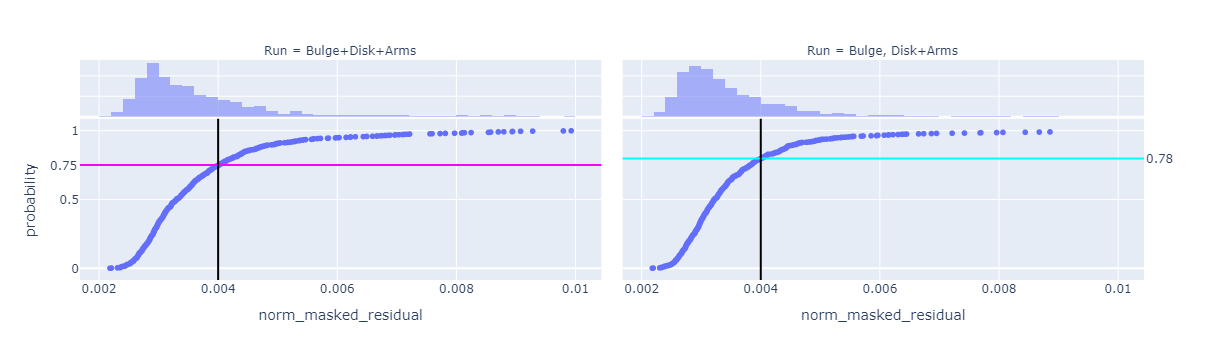

In [319]:
fig = px.ecdf(graphing_df, 
              x = nmr, 
              markers = True, 
              lines = False, 
              facet_col = "Run ", 
              marginal = "histogram") #, facet_col_wrap = 1) # 

fig.add_hline(y = 0.75, 
              row = 1,
              col = 1,
              line_color = "magenta",
              annotation_text="0.75", #from Run2", 
              annotation_position="left")

fig.add_hline(y = 0.798,
              row = 1,
              col = 2,
              line_color = "cyan",
              annotation_text="0.78", # from Run6", 
              annotation_position="right")

fig.add_vline(x = 0.004, 
              row = 1,
              line_color = "black")
              #annotation_text="Cutoff", 
              #annotation_position="bottom")

# fig.add_trace(go.Scatter(x = np.ones(len(nmr2_lim))*0.004, y = np.linspace(0,1,num = len(nmr2_lim)), mode = "lines"))
# fig.add_trace(go.Scatter(x = np.linspace(0.002, 0.01, num = len(nmr2_lim)), y = np.ones(len(nmr2_lim))*0.75, mode = "lines"))

# fig.add_trace(go.Scatter(x = np.ones(len(nmr2_lim))*0.004, y = np.linspace(0,1,num = len(nmr2_lim))))
# fig.add_trace(go.Scatter(x = np.linspace(0.002, 0.01, num = len(nmr2_lim)), y = np.ones(len(nmr2_lim))*0.75))


fig.show()

In [311]:
#print(len(test_list), len(norms), 717/809*100)
cutoff_val = 0.004
run2_name = run2_name.strip()
run6_name = run6_name.strip()

print(f"Total number of galaxies attempted: {total_gal}")
print()
print(f"Number of Galfit models generated...")
print(f"{run2_name} : {len(norms2_df)}/{total_gal}")
print(f"{run6_name}: {len(norms6_df)}/{total_gal}")

cutoff2 = norms2_df.query(f"{nmr} < {cutoff_val}")
cutoff6 = norms6_df.query(f"{nmr} < {cutoff_val}")
print()
print(f"Residuals below {cutoff_val} cutoff for (excluding failures)...")
print(f"{run2_name} : {len(cutoff2)}/{len(norms2_df)}, {100*len(cutoff2)/len(norms2_df):.2f}%")
print(f"{run6_name}: {len(cutoff6)}/{len(norms6_df)}, {100*len(cutoff6)/len(norms6_df):.2f}%")

Total number of galaxies attempted: 1000

Number of Galfit models generated...
Bulge+Disk+Arms : 902/1000
Bulge, Disk+Arms: 995/1000

Residuals below 0.004 cutoff for (excluding failures)...
Bulge+Disk+Arms : 633/902, 70.18%
Bulge, Disk+Arms: 766/995, 76.98%


In [368]:
def generate_images(input_df, png_dir:str, cutoff = 0.004, custom_range = None):
    images_below_cutoff = []
    images_above_cutoff = []
    
    if not custom_range:
        custom_range = range(0, len(input_df), 50) 
    
    for index_num in custom_range:
        galaxy_info = input_df.iloc[index_num]

        # iloc returns a series, name returns the name of the row

        print(f"{galaxy_info.name.rstrip('_out.fits')}, sorted #: {index_num}")
        # print(f"chi^2/nu = {galaxy_info['chi^2_nu']:.2f}")
        # print(f"chi^2 = {galaxy_info['chi^2']:.2f}")
        print(f"Norm masked residual = {galaxy_info[nmr]:.6f}")
        print(f"Dim: {galaxy_info['image_size']}x{galaxy_info['image_size']}")
        print()
        #print(f"Norm GALFIT residual = {norm_galfit_residual:.4f}")


        # galfit_cmap = grayscale_cmap('RdBu')
        # residual_plot = plt.imshow(np.flipud(masked_residual[:,:])) #, norm=colors.LogNorm())
        # residual_plot.set_cmap('Greys')
        # residual_plot.set_cmap(galfit_cmap)
        # cbar = plt.colorbar()

        #plt.imshow(residual_plot)
        #imgplot = plt.imshow(arr[:, :, 0])
        out_str = galaxy_info.name.replace("out.fits", "combined.png").strip()
        if galaxy_info[nmr] < cutoff_val:
            images_below_cutoff.append(Image(filename = os.path.join(png_dir, out_str), width=500, height=500))
        else:
            images_above_cutoff.append(Image(filename = os.path.join(png_dir, out_str), width=500, height=500))
            
    return images_below_cutoff, images_above_cutoff

In [377]:
# https://stackoverflow.com/questions/32370281/how-to-embed-image-or-picture-in-jupyter-notebook-either-from-a-local-machine-o
# Could also be useful https://eltos.github.io/gradient/#FFFFFF-A5A5A5-000000-A5A5A5-FFFFFF
png_dir6 = os.path.join(run_path6, sparc_out, galfit_out, "galfit_png/")
images_below_cutoff, images_above_cutoff = generate_images(norms6_df, png_dir6, cutoff = 0.004)

1237671262278582530, sorted #: 0
Norm masked residual = 0.002181
Dim: 101x101

1237667967495897277, sorted #: 50
Norm masked residual = 0.002567
Dim: 35x35

1237667549812424839, sorted #: 100
Norm masked residual = 0.002674
Dim: 61x61

1237668348139143386, sorted #: 150
Norm masked residual = 0.002748
Dim: 43x43

1237667443508117572, sorted #: 200
Norm masked residual = 0.002826
Dim: 95x95

1237668272974463058, sorted #: 250
Norm masked residual = 0.002911
Dim: 41x41

1237668298214408294, sorted #: 300
Norm masked residual = 0.002984
Dim: 57x57

1237667782855950613, sorted #: 350
Norm masked residual = 0.003045
Dim: 61x61

1237671128589533325, sorted #: 400
Norm masked residual = 0.003119
Dim: 67x67

1237668588654297228, sorted #: 450
Norm masked residual = 0.003198
Dim: 75x75

1237668272975642825, sorted #: 500
Norm masked residual = 0.003292
Dim: 67x67

1237667539083395164, sorted #: 550
Norm masked residual = 0.003383
Dim: 41x41

1237667781750489228, sorted #: 600
Norm masked residu

In [ ]:
display(*images_below_cutoff)

In [ ]:
display(*images_above_cutoff)

In [375]:
size_sorted2 = norms2_df.sort_values(by=['image_size'])[::-1]
size_sorted6 = norms6_df.sort_values(by=['image_size'])[::-1]

In [382]:
png_dir2 = os.path.join(run_path2, sparc_out, galfit_out, "galfit_png/")
top_10_by_size2, _ = generate_images(size_sorted2, png_dir2, cutoff = 0.004, custom_range = range(10))
print("=============================================\n")
top_10_by_size6, _ = generate_images(size_sorted6, png_dir6, cutoff = 0.004, custom_range = range(10))

1237671265495417081, sorted #: 0
Norm masked residual = 0.002460
Dim: 195x195

1237667442968100920, sorted #: 1
Norm masked residual = 0.002565
Dim: 121x121

1237667781205426253, sorted #: 2
Norm masked residual = 0.003727
Dim: 119x119

1237667910589874539, sorted #: 3
Norm masked residual = 0.002479
Dim: 109x109

1237667537465770069, sorted #: 4
Norm masked residual = 0.031428
Dim: 103x103

1237668271363260566, sorted #: 5
Norm masked residual = 0.003056
Dim: 101x101

1237671262278582530, sorted #: 6
Norm masked residual = 0.002185
Dim: 101x101

1237667446733734187, sorted #: 7
Norm masked residual = 0.002543
Dim: 99x99

1237667915951833160, sorted #: 8
Norm masked residual = 0.002732
Dim: 97x97

1237668585969418348, sorted #: 9
Norm masked residual = 0.002725
Dim: 97x97


1237671265495417081, sorted #: 0
Norm masked residual = 0.002443
Dim: 195x195

1237668496321019995, sorted #: 1
Norm masked residual = 0.015393
Dim: 169x169

1237667442968100920, sorted #: 2
Norm masked residual = 0

In [ ]:
display(*top_10_by_size2)

In [10]:
# Grab top 1000 highest resolution galaxies from Darren's 27K and run this on those
# Change pitch angle plotting to only plot sparcfire's line between r_in and r_out and see how that compare to galfit
# Tile residuals for presentation???

In [132]:
# Thanks to https://jakevdp.github.io/PythonDataScienceHandbook/04.07-customizing-colorbars.html
def grayscale_cmap(cmap):
    """Return a grayscale version of the given colormap"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    # convert RGBA to perceived grayscale luminance
    # cf. http://alienryderflex.com/hsp.html
    RGB_weight = [0.299, 0.587, 0.114]
    luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
    colors[:, :3] = luminance[:, np.newaxis]
        
    return LinearSegmentedColormap.from_list(cmap.name + "_gray", colors, cmap.N)